## Imports

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score, classification_report, confusion_matrix
from utils import find_knn_per_class, apply_smote
import re
from collections import defaultdict
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from collections import Counter
from xgboost import XGBClassifier
from sklearn.preprocessing import label_binarize
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
from tqdm import tqdm



## Data preprocessing

In [27]:
data = np.load("data_files/full_acoustic_dataset.npz", allow_pickle=True)
labeled_x = data['labeled_x']
labeled_y = data['labeled_y']
unlabeled_x = data['unlabeled_x']
unlabeled_meta = data['unlabeled_meta']
labeled_meta = data['labeled_meta']


In [28]:
# === Split original labeled data for validation ===
train_labeled_x, val_x, train_labeled_y, val_y = train_test_split(
    labeled_x, labeled_y, test_size=0.2, stratify=labeled_y, random_state=35
)

# === Pseudo-labeling from training set only ===
all_new_x = []
all_new_y = []

for cls in np.unique(train_labeled_y):
    results, new_x, new_y, unlabeled_x, unlabeled_meta = find_knn_per_class(
        train_labeled_x, train_labeled_y,
        unlabeled_x, unlabeled_meta,
        target_class=cls,
        max_K=10,
        distance_threshold=500
    )
    print(f"Class {cls}: added {len(new_y)} new samples.")
    all_new_x.append(new_x)
    all_new_y.append(new_y)

pseudo_x = np.vstack(all_new_x)
pseudo_y = np.concatenate(all_new_y)

print("Final up-sampled size:", pseudo_x.shape)
print("Remaining unlabeled:", unlabeled_x.shape)

# === Combine and apply SMOTE ===
all_train_x = np.concatenate([train_labeled_x, pseudo_x])
all_train_y = np.concatenate([train_labeled_y, pseudo_y])

print("Original class distribution:", Counter(all_train_y))
X_resampled, y_resampled = apply_smote(all_train_x, all_train_y)
print("Resampled class distribution:", Counter(y_resampled))

Class 0: added 118 new samples.
Class 1: added 2208 new samples.
Final up-sampled size: (2326, 25)
Remaining unlabeled: (13142157, 25)
Original class distribution: Counter({np.int64(1): 2470, np.int64(0): 256})
Original class distribution: Counter({np.int64(1): 2470, np.int64(0): 256})
Resampled class distribution: Counter({np.int64(0): 2470, np.int64(1): 2470})
Resampled class distribution: Counter({np.int64(0): 2470, np.int64(1): 2470})


## Random forest

In [29]:
rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_resampled, y_resampled)

probs = rf_model.predict_proba(val_x)
preds = rf_model.predict(val_x)

print("Evaluation:")
print(f"Accuracy: {accuracy_score(val_y, preds):.4f}")
print(f"F1 Score (macro): {f1_score(val_y, preds, average='macro'):.4f}")
print(f"F1 Score (weighted): {f1_score(val_y, preds, average='weighted'):.4f}")

Evaluation:
Accuracy: 0.9208
F1 Score (macro): 0.9137
F1 Score (weighted): 0.9213


In [30]:
print("\nPer-Class Classification Report:")
print(classification_report(val_y, preds, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(val_y, preds))



Per-Class Classification Report:
              precision    recall  f1-score   support

           0     0.8649    0.9143    0.8889        35
           1     0.9531    0.9242    0.9385        66

    accuracy                         0.9208       101
   macro avg     0.9090    0.9193    0.9137       101
weighted avg     0.9225    0.9208    0.9213       101

Confusion Matrix:
[[32  3]
 [ 5 61]]


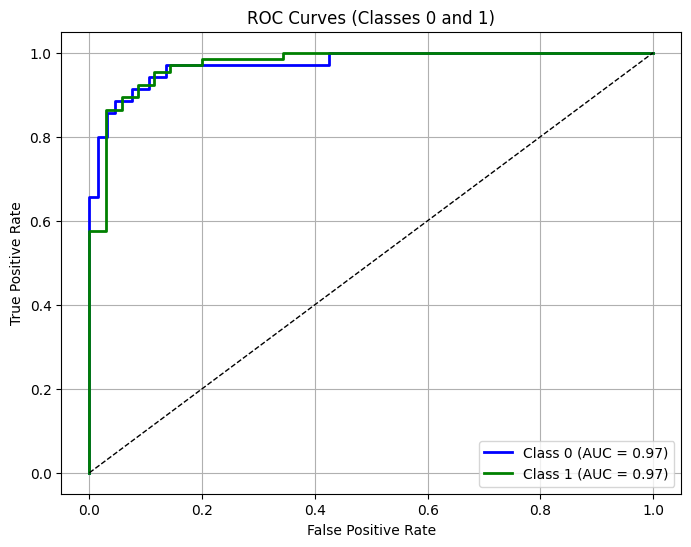

In [31]:
y_bin = label_binarize(val_y, classes=[0, 1])
if y_bin.shape[1] == 1:
    y_bin = np.hstack((1 - y_bin, y_bin))
fpr = {}
tpr = {}
roc_auc = {}

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['blue', 'green']
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Classes 0 and 1)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## XGBoost

In [32]:
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.005,
    subsample=0.9,
    colsample_bytree=0.8,
    eval_metric='logloss'
)

xgb_model.fit(X_resampled, y_resampled)

probs = xgb_model.predict_proba(val_x)
preds = xgb_model.predict(val_x)

print("Evaluation:")
print(f"Accuracy: {accuracy_score(val_y, preds):.4f}")
print(f"F1 Score (macro): {f1_score(val_y, preds, average='macro'):.4f}")
print(f"F1 Score (weighted): {f1_score(val_y, preds, average='weighted'):.4f}")

Evaluation:
Accuracy: 0.9307
F1 Score (macro): 0.9249
F1 Score (weighted): 0.9313


In [33]:
print("\nPer-Class Classification Report:")
print(classification_report(val_y, preds, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(val_y, preds))



Per-Class Classification Report:
              precision    recall  f1-score   support

           0     0.8684    0.9429    0.9041        35
           1     0.9683    0.9242    0.9457        66

    accuracy                         0.9307       101
   macro avg     0.9183    0.9335    0.9249       101
weighted avg     0.9337    0.9307    0.9313       101

Confusion Matrix:
[[33  2]
 [ 5 61]]


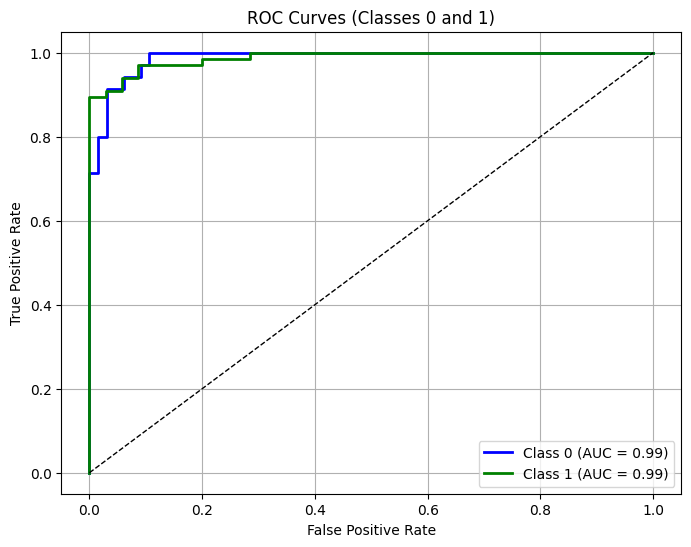

In [34]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

y_bin = label_binarize(val_y, classes=[0, 1])
if y_bin.shape[1] == 1:
    y_bin = np.hstack((1 - y_bin, y_bin))
fpr = {}
tpr = {}
roc_auc = {}

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['blue', 'green']
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Classes 0 and 1)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [42]:
# === Predict on full unlabeled set ===
unlabeled_probs = rf_model.predict_proba(unlabeled_x)
unlabeled_preds = rf_model.predict(unlabeled_x)
confidence_threshold = 0.95

final_unlabeled_preds = np.array([
    p if max(prob) >= confidence_threshold else 2
    for p, prob in zip(unlabeled_preds, unlabeled_probs)
])

# === Print stats ===
distribution = Counter(final_unlabeled_preds)
total = len(final_unlabeled_preds)
print("\nFinal Unlabeled Predictions Distribution:")
for label, count in distribution.items():
    pct = (count / total) * 100
    print(f"Class {label}: {count} ({pct:.2f}%)")



Final Unlabeled Predictions Distribution:
Class 1: 2160801 (16.44%)
Class 2: 10914221 (83.05%)
Class 0: 67135 (0.51%)


In [49]:
def postprocess_class1_sequences(unlabeled_x, unlabeled_y, unlabeled_meta, time_gap_threshold_us=5_000_000):
    feature_column_names = [
        'ClksThisMin', 'NofClx', 'medianKHz', 'avSPL', 'avPkAt',
        'AvPRF', 'avEndF', 'tWUTrisk', 'nActualClx', 'nRisingIPIs',
        'TrDur_us', 'nICIrising',
        'MinICI_us', 'midpointICI', 'MaxICI_us', 'ClkNofMinICI',
        'ClkNofMaxICI', 'NofClstrs',
        'avClstrNx8', 'avPkIPI', 'BeforeIPIratio', 'PreIPIratio',
        'Post1IPIratio', 'Post2IPIratio', 'EndIPIratio'
    ]
    trdur_idx =  feature_column_names.index('TrDur_us') 
    
    data_by_location = defaultdict(list)
    for idx, meta in enumerate(unlabeled_meta):
        location, minute_str, micro_str = meta
        start_us = np.int64(int(minute_str)) * 60 * 1_000_000 + np.int64(int(micro_str))
        duration_us = np.int64(unlabeled_x[idx, trdur_idx])
        end_us = start_us + duration_us
        data_by_location[location].append((start_us, end_us, idx))
    for loc in data_by_location:
        data_by_location[loc].sort()
    new_labels = unlabeled_y.copy()
    
    for loc, entries in data_by_location.items():
        class1_entries = [(s, e, i) for (s, e, i) in entries if unlabeled_y[i] == 1]
        class1_entries.sort()
        
        current_sequence = []
        for j in range(len(class1_entries)):
            s, e, idx = class1_entries[j]
            if not current_sequence:
                current_sequence.append((s, e, idx))
            else:
                prev_s, prev_e, _ = current_sequence[-1]
                if s - prev_e <= time_gap_threshold_us:
                    current_sequence.append((s, e, idx))
                else:
                    if len(current_sequence) >= 2:
                        for _, _, seq_idx in current_sequence:
                            new_labels[seq_idx] = 1
                    else:
                        for _, _, seq_idx in current_sequence:
                            new_labels[seq_idx] = 2
                    current_sequence = [(s, e, idx)]
        
        if current_sequence:
            if len(current_sequence) >= 2:
                for _, _, seq_idx in current_sequence:
                    new_labels[seq_idx] = 1
            else:
                for _, _, seq_idx in current_sequence:
                    new_labels[seq_idx] = 2
                    
    return new_labels

new_labels = postprocess_class1_sequences(unlabeled_x, final_unlabeled_preds, unlabeled_meta)

In [51]:
distribution = Counter(new_labels)
total = len(new_labels)
print("\nFinal Unlabeled Predictions Distribution:")
for label, count in distribution.items():
    pct = (count / total) * 100
    print(f"Class {label}: {count} ({pct:.2f}%)")


Final Unlabeled Predictions Distribution:
Class 2: 11860451 (90.25%)
Class 1: 1214571 (9.24%)
Class 0: 67135 (0.51%)


In [ ]:
class AcousticSequenceDataset(Dataset):
    def __init__(self, data_dir, excel_path=None, target_length=128, click_filter=None,
                 id_columns=('File', 'Minute', 'Time')):
        self.data_dir = data_dir
        self.target_length = target_length
        self.click_filter = click_filter
        self.id_columns = id_columns
        self.label_encoder = LabelEncoder()

        self.labeled_timeseries = []
        self.identities = []
        self.labels_for_labeled_data = []

        self.labeled_data = pd.DataFrame()
        self.labels = []
        self.labeled_indices = set()
        self.identity_to_label = {}

        if excel_path:
            self._load_labeled_data(excel_path)

        self.unlabeled_sequences, self.unlabeled_metadata = self._load_and_process_files()

    def _load_labeled_data(self, excel_path):
        xl = pd.ExcelFile(excel_path)
        dfs = []
        for sheet in xl.sheet_names:
            df = xl.parse(sheet)
            df['label'] = sheet  
            dfs.append(df)
        full_labeled = pd.concat(dfs, ignore_index=True)

        full_labeled[self.id_columns[0]] = full_labeled[self.id_columns[0]].astype(str)
        full_labeled[self.id_columns[1]] = full_labeled[self.id_columns[1]].astype(int)
        full_labeled[self.id_columns[2]] = full_labeled[self.id_columns[2]].astype(int)

        self.labeled_data = full_labeled
        self.labels = self.label_encoder.fit_transform(full_labeled['label'])
        self.labeled_indices = set(full_labeled[list(self.id_columns)].apply(tuple, axis=1))

        self.identity_to_label = {
            tuple(row[col] for col in self.id_columns): label
            for row, label in zip(full_labeled.to_dict(orient="records"), self.labels)
        }

    def _load_and_process_files(self):
        sequences = []
        metadata = []

        for file in os.listdir(self.data_dir):
            path = os.path.join(self.data_dir, file)
            try:
                df = pd.read_csv(path, sep="\t", usecols=['Minute', 'microsec', 'ICI', 'File'])
            except Exception as e:
                print(f"Failed to read {file}: {e}")
                continue
            if df.empty:
                continue
            file_name = df['File'][0]
            df["Datetime"] = datetime(1899, 12, 30) + pd.to_timedelta(df["Minute"], unit="m") + pd.to_timedelta(
                df["microsec"], unit="us")
            df["Clk/s"] = (1 / df["ICI"]) * 10 ** 6

            df.drop(columns=['File'], inplace=True)
            df['Datetime'] = pd.to_datetime(df['Datetime'])
            df.set_index('Datetime', inplace=True)

            clk_values = df['Clk/s'].values
            is_inf = np.isinf(clk_values)
            split_indices = np.where(is_inf)[0]
            start_idx = 0
            for end_idx in split_indices:
                instance = df.iloc[start_idx:end_idx]

                if len(instance) < 3:
                    start_idx = end_idx + 1
                    continue

                if self.click_filter and not self.click_filter(instance):
                    start_idx = end_idx + 1
                    continue

                if start_idx > 0:
                    anchor_row = df.iloc[start_idx - 1]
                    minute = int(anchor_row['Minute'])
                    microsec = int(anchor_row['microsec'])
                else:
                    minute = int(df['Minute'].iloc[start_idx])
                    microsec = int(df['microsec'].iloc[start_idx])

                if instance.isnull().all().any():
                    start_idx = end_idx + 1
                    continue

                time_values = (instance.index - instance.index[0]).total_seconds().astype(np.float32)
                clk_values = instance['Clk/s'].values.astype(np.float32)

                if len(time_values) < 2 or np.all(time_values == time_values[0]):
                    start_idx = end_idx + 1
                    continue
                    
                identity = (file_name, minute, microsec)

                if identity in self.identity_to_label:
                    self.labeled_timeseries.append(clk_values)
                    self.identities.append(identity)
                    self.labels_for_labeled_data.append(self.identity_to_label[identity])
                else:
                    sequences.append(clk_values)
                    metadata.append(identity)

                start_idx = end_idx + 1

        return sequences, metadata

    def get_labeled(self):
        return (
            self.labeled_timeseries,
            np.array(self.labels_for_labeled_data, dtype=np.int64),
            self.labeled_data[list(self.id_columns)],
            np.array(self.identities),
        )

    def get_unlabeled(self):
        return self.unlabeled_sequences, self.unlabeled_metadata

    def __len__(self):
        return len(self.labeled_timeseries)

    def __getitem__(self, idx):
        return self.labeled_timeseries[idx]

click_dataset = AcousticSequenceDataset(
    'data_files/unlabeled_data',
    excel_path="data_files/datasets/CLICK TRAINS.xlsx",
    target_length=64,
    click_filter=None,
    id_columns=('File', 'Minute', 'Time')
)

signal_x, signal_meta = click_dataset.get_unlabeled()

In [34]:
special_areas = ['U Dzha Bay', 'U Dzha Sea']

signal_meta = np.array(signal_meta)
def extract_area_name(entry):
    entry_str = str(entry)
    for area in special_areas:
        if entry_str.startswith(area):
            return area
    match = re.match(r'^(\w+ \w+)', entry_str)
    return match.group(1) if match else entry_str

vectorized_extractor = np.vectorize(extract_area_name)

clean_unlabeled_meta = vectorized_extractor(signal_meta[:, 0])
meta_signal = np.column_stack((clean_unlabeled_meta, signal_meta[:, 1:3]))

In [13]:
def save_labeled_visuals_by_location(
    labeled_x, labeled_y, labeled_meta,
    signal_x, signal_meta,
    location_filter='U Dzha Bay',
    save_dir='labeled_data_visuals',
    save_waveform_plot=True,
    max_per_class=30
):
    os.makedirs(save_dir, exist_ok=True)

    feature_column_names = [
        'ClksThisMin', 'NofClx', 'medianKHz', 'avSPL', 'avPkAt',
        'AvPRF', 'avEndF', 'tWUTrisk', 'nActualClx', 'nRisingIPIs',
        'TrDur_us', 'nICIrising',
        'MinICI_us', 'midpointICI', 'MaxICI_us', 'ClkNofMinICI',
        'ClkNofMaxICI', 'NofClstrs',
        'avClstrNx8', 'avPkIPI', 'BeforeIPIratio', 'PreIPIratio',
        'Post1IPIratio', 'Post2IPIratio', 'EndIPIratio'
    ]

    class_dirs = {
        0: os.path.join(save_dir, "class_0"),
        1: os.path.join(save_dir, "class_1"),
        2: os.path.join(save_dir, "noise")
    }
    for d in class_dirs.values():
        os.makedirs(d, exist_ok=True)

    # Filter labeled samples by location
    filtered = [
        (x, y, meta) for x, y, meta in zip(labeled_x, labeled_y, labeled_meta)
        if meta[0] == location_filter
    ]

    if not filtered:
        print(f"No labeled instances found for location: {location_filter}")
        return

    signal_lookup = {tuple(m): s for s, m in zip(signal_x, signal_meta)}
    saved_counts = {0: 0, 1: 0, 2: 0}

    for i, (x, y, meta) in enumerate(tqdm(filtered)):
        identity = tuple(meta)
        raw_signal = signal_lookup.get(identity, None)

        if raw_signal is None:
            continue

        final_class = y if y in [0, 1] else 2
        if saved_counts[final_class] >= max_per_class:
            continue

        label_dir = class_dirs[final_class]
        base_name = f"{i}_{identity[0].replace(' ', '_')}_{identity[1]}_{identity[2]}"

        # Save feature vector
        df_feat = pd.DataFrame([x], columns=feature_column_names)
        df_feat.to_csv(os.path.join(label_dir, f"{base_name}_features.csv"), index=False)

        # Save waveform CSV
        # np.savetxt(os.path.join(label_dir, f"{base_name}_waveform.csv"), raw_signal, delimiter=",")

        # Save waveform PNG
        if save_waveform_plot:
            plt.figure(figsize=(6, 3))
            plt.plot(raw_signal, lw=1)
            plt.title(f"Label: Class {final_class}")
            plt.xlabel("Time (sampled)")
            plt.ylabel("Clk/s")
            plt.tight_layout()
            plt.savefig(os.path.join(label_dir, f"{base_name}_waveform.png"))
            plt.close()

        saved_counts[final_class] += 1

        if all(saved_counts[c] >= max_per_class for c in saved_counts):
            print("Saved max limit for all classes. Stopping.")
            break

    print(f"Saved labeled data for location: {location_filter} to: {save_dir}")
    print(f"Saved counts: {saved_counts}")
    
save_labeled_visuals_by_location(
    unlabeled_x, final_unlabeled_preds, unlabeled_meta,
    signal_x, meta_signal,
    location_filter='U Kinburn',
    save_dir='Kinburn_data_visuals',
    save_waveform_plot=True,
    max_per_class=100
)

  7%|▋         | 15885/237447 [00:08<01:59, 1854.49it/s]


Saved max limit for all classes. Stopping.
Saved per-class predictions for location: G Anaklia to: anaklia_predictions
Saved counts: {0: 20, 1: 20, 2: 20}
